# Mini-Lab: Logistic Regression and SVMs (Modeling)

__Team Members__
- Name 1: Jorge Olmos
- Name 2: Bosang Yun
- Name 3: Yucheol Shin
- Name 4: Siu Wai Yeung

# Content
* [Data Importing and Cleaning](#Data-Importing-and-Cleaning)
* [Select Modeling Techniques](#Select-Modeling-Techniques)
* [Generate Test Design](#Generate-Test-Design)
* [Build Model](#Build-Model)
* [Assess Model](#Assess-Model)


# Data Importing and Cleaning<a id='Data-Importing-and-Cleaning'/>

In [ ]:
import pandas as pd
import numpy as np

hotel_bookings = pd.read_csv('https://raw.githubusercontent.com/olmosjorge28/DS7331_ML1_ASSINGMENTS/main/hotel_bookings.csv') # read in the csv file
hotel_bookings.head()

In [6]:
import math

hotel_bookings_transform = hotel_bookings
hotel_bookings_transform= hotel_bookings_transform.drop(columns=['agent','company', 'country'])

hotel_bookings_transform['meal']= hotel_bookings_transform['meal'].apply(lambda x: 'SC' if  x == 'Undefined'  else x)
hotel_bookings_transform['children']= hotel_bookings_transform['children'].apply(lambda x: 0 if  math.isnan(x)  else x)
hotel_bookings_transform['market_segment']= hotel_bookings_transform['market_segment'].apply(lambda x: 'Online TA' if  x == 'Undefined'  else x)
hotel_bookings_transform['distribution_channel']= hotel_bookings_transform['distribution_channel'].apply(lambda x: 'TA/TO' if  x == 'Undefined'  else x)


hotel_bookings_transform['hotel']=hotel_bookings_transform['hotel'].astype('category').cat.codes
hotel_bookings_transform['market_segment']=hotel_bookings_transform['market_segment'].astype('category').cat.codes
hotel_bookings_transform['meal']=hotel_bookings_transform['meal'].astype('category').cat.codes
hotel_bookings_transform['reservation_status']=hotel_bookings_transform['reservation_status'].astype('category').cat.codes
hotel_bookings_transform['distribution_channel']=hotel_bookings_transform['distribution_channel'].astype('category').cat.codes
hotel_bookings_transform['reserved_room_type']=hotel_bookings_transform['reserved_room_type'].astype('category').cat.codes
hotel_bookings_transform['assigned_room_type']=hotel_bookings_transform['assigned_room_type'].astype('category').cat.codes
hotel_bookings_transform['deposit_type']=hotel_bookings_transform['deposit_type'].astype('category').cat.codes
hotel_bookings_transform['customer_type']=hotel_bookings_transform['customer_type'].astype('category').cat.codes

assign_month = {"arrival_date_month": {"January": 1, "February": 2, "March": 3, "April": 4,"May": 5,"June": 6,"July": 7,"August": 8,"September": 9,"October": 10,"November": 11,"December": 12}}
hotel_bookings_transform = hotel_bookings_transform.replace(assign_month)

# Convert Date to Ordinal
import datetime as dt
hotel_bookings_transform['reservation_status_date'] = pd.to_datetime(hotel_bookings_transform['reservation_status_date'])
hotel_bookings_transform['reservation_status_date'] = hotel_bookings_transform['reservation_status_date'].map(dt.datetime.toordinal)

# Select Modeling Techniques<a id='Select-Modeling-Techniques'/>

In [7]:
## todo:

# Generate Test Design: <a id='Generate-Test-Design'/>

## Normalization

- SVM tries to maximize the distance between the support vectors and the separating plane. 
- Prior to conducting SVM, we need to normalize the dataset so we can get rid of bias and dominance of certain features over others. 
- The result of applying normalized dataset will be having the same influence on the distance metric, thus boosting the accuracy of the model. 

In [8]:
X=hotel_bookings_transform.drop(columns=['is_canceled','reservation_status','meal'])
y=hotel_bookings_transform.is_canceled
columns = X.columns

In [9]:
from sklearn import preprocessing
scaler = preprocessing.StandardScaler().fit(X)
scaler

scaler.mean_
scaler.scale_

X_scaled = pd.DataFrame(scaler.transform(X),columns=columns)

Verifying each feature has a mean of zero:

In [10]:
X_scaled.mean(axis=0)

hotel                            -2.148285e-13
lead_time                         3.358325e-16
arrival_date_year                 7.194355e-14
arrival_date_month               -1.221612e-14
arrival_date_week_number          4.093983e-15
arrival_date_day_of_month        -9.159196e-16
stays_in_weekend_nights           3.928971e-14
stays_in_week_nights             -2.182022e-14
adults                            5.708995e-15
children                         -6.989886e-16
babies                            5.955017e-15
market_segment                    4.484909e-15
distribution_channel              2.185129e-14
is_repeated_guest                -3.493540e-14
previous_cancellations            1.741766e-14
previous_bookings_not_canceled   -1.286381e-15
reserved_room_type                1.246924e-13
assigned_room_type                9.462049e-14
booking_changes                  -7.015186e-14
deposit_type                      1.754553e-13
days_in_waiting_list             -1.846956e-14
customer_type

Verifying that the standard deviation should be 1:

In [11]:
X_scaled.std(axis=0)

hotel                             1.000004
lead_time                         1.000004
arrival_date_year                 1.000004
arrival_date_month                1.000004
arrival_date_week_number          1.000004
arrival_date_day_of_month         1.000004
stays_in_weekend_nights           1.000004
stays_in_week_nights              1.000004
adults                            1.000004
children                          1.000004
babies                            1.000004
market_segment                    1.000004
distribution_channel              1.000004
is_repeated_guest                 1.000004
previous_cancellations            1.000004
previous_bookings_not_canceled    1.000004
reserved_room_type                1.000004
assigned_room_type                1.000004
booking_changes                   1.000004
deposit_type                      1.000004
days_in_waiting_list              1.000004
customer_type                     1.000004
adr                               1.000004
required_ca

## Feature Selection 

Running initial model to select best parameters to be used for RFE selection:

In [12]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import ShuffleSplit

#cv = ShuffleSplit(n_splits=10, test_size=0.10, random_state=0)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y,test_size=0.2,random_state=10)

regEstimator = LogisticRegression()

parameters = { 'penalty':['l2']
              ,'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]
              ,'class_weight': ['balanced','none']
              ,'random_state': [10]
              ,'solver': ['lbfgs']
              ,'max_iter':[500,1000]
             }


from sklearn.model_selection import GridSearchCV
regGridSearch = GridSearchCV(estimator=regEstimator
                   , n_jobs=8 # jobs to run in parallel
                   , verbose=1 # low verbosity
                   , param_grid=parameters
                   , scoring='accuracy')

regGridSearch.fit(X_train, y_train)

Fitting 5 folds for each of 28 candidates, totalling 140 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:   10.7s
[Parallel(n_jobs=8)]: Done 140 out of 140 | elapsed:  1.3min finished


GridSearchCV(estimator=LogisticRegression(), n_jobs=8,
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
                         'class_weight': ['balanced', 'none'],
                         'max_iter': [500, 1000], 'penalty': ['l2'],
                         'random_state': [10], 'solver': ['lbfgs']},
             scoring='accuracy', verbose=1)

### RFE Selection

In [13]:
from sklearn.feature_selection import RFECV

#Create a regression estimator with best parameters for cross validation
classifierEst = regGridSearch.best_estimator_

#for loop
rfecv = RFECV(estimator=classifierEst, step=1, scoring='accuracy')
rfecv.fit(X_train, y_train)

/Users/boyun/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/boyun/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logis

RFECV(estimator=LogisticRegression(C=1000, class_weight='balanced',
                                   max_iter=500, random_state=10),
      scoring='accuracy')

Here we're examining the plot of the categorical values of interest and looking at the optimal number of features:

Optimal number of features : 24


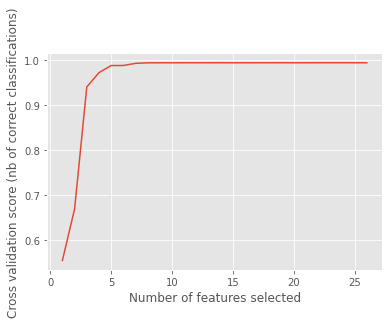

In [16]:
# Examine categorical variables of interest  
import matplotlib.pyplot as plt
%matplotlib inline

print("Optimal number of features : %d" % rfecv.n_features_)

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

In [17]:
#Plot the RFE Rankings
plt.style.use('ggplot')

rfe_ft_imp_df = pd.DataFrame({'feature_names':X_scaled.columns, 'weights':rfecv.grid_scores_})
rfe_ft_imp_df.sort_values(by='weights', inplace=True, ascending=False )

top_features = rfe_ft_imp_df.head(50)

top_features

,feature_names,weights
23,required_car_parking_spaces,0.993770
13,is_repeated_guest,0.993749
18,booking_changes,0.993739
21,customer_type,0.993739
24,total_of_special_requests,0.993729
22,adr,0.993729
20,days_in_waiting_list,0.993708
15,previous_bookings_not_canceled,0.993697
12,distribution_channel,0.993687
17,assigned_room_type,0.993676


### Embedded method for feature selection
- 26 features are selected based on the weight distribution from the Recurvesive features selection result. 
- Embedded method is utilized to reduce the number of features further down with Lasso regularization method.
- LASSO regularization method penalizes coefficients of features and remove those that are with coefficient=0.
- A total of 7 features are selected : 
    - 'adr'
    - 'total_of_special_requests'
    - 'deposit_type'
    - 'booking_changes'
    - 'distribution_channel'
    - 'assigned_room_type'
    - 'market_segment'

In [19]:
# Passing in features that are selected from RFE result into X_sel 

X_sel = X_scaled[['is_repeated_guest',
'customer_type',
'adr',
'days_in_waiting_list',
'reservation_status_date',
'total_of_special_requests',
'deposit_type',
'booking_changes',
'previous_bookings_not_canceled',
'distribution_channel',
'assigned_room_type',
'market_segment',
'babies',
'adults',
'previous_cancellations',
'children',
'reserved_room_type',
'stays_in_week_nights',
'stays_in_weekend_nights']]

X_sel.drop('target',axis=1, inplace=True)

In [20]:
from sklearn.linear_model import LassoCV

reg = LassoCV()
reg.fit(X_sel, y)
print("Best alpha using built-in LassoCV: %f" % reg.alpha_)
print("Best score using built-in LassoCV: %f" %reg.score(X_sel,y))
coef = pd.Series(reg.coef_, index = X_sel.columns)

Best alpha using built-in LassoCV: 0.034397
Best score using built-in LassoCV: 0.250490


In [87]:
print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")

Lasso picked 7 variables and eliminated the other 12 variables


Text(0.5, 1.0, 'Feature importance using Lasso Model')

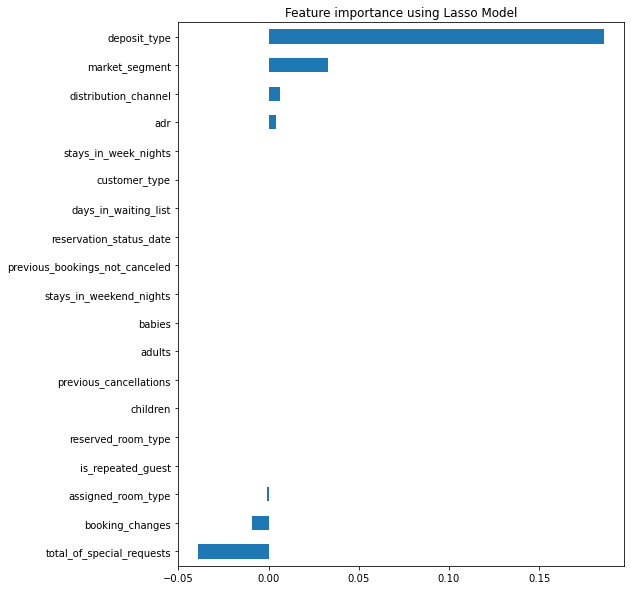

In [88]:
# Visualizing the feature importance using LASSO 

import matplotlib.pyplot as plt
imp_coef = coef.sort_values()
import matplotlib
matplotlib.rcParams['figure.figsize'] = (8.0, 10.0)
imp_coef.plot(kind = "barh")
plt.title("Feature importance using Lasso Model")

## Cross Validation
- We applied the feature selection from above and decided to use 80:20 training/test split along with using gridSearch. 
- We will be using gridSearch function, which has 5 fold cross validation. 

In [61]:
from sklearn.model_selection import StratifiedShuffleSplit 
from sklearn.model_selection import train_test_split
from sklearn import metrics as mt

X_sel = X_scaled[[
'adr',
'total_of_special_requests',
'deposit_type',
'booking_changes',
'distribution_channel',
'assigned_room_type',
'market_segment',
'lead_time'
]]


X_train, X_test, y_train, y_test = train_test_split(X_sel, y,test_size=0.2,random_state=10)

# Build Model<a id='Build-Model'/>

To build our model, after analyzing our feature selection we decided to keep all features that had weights greater than .9

## Logistic Regression 

### Why do you think some variables are more important?

Doing f1 scoring, which is best for a binary target like is_canceled

In [91]:
from sklearn.linear_model import LogisticRegression
regEstimator = LogisticRegression()


tuning_parameters = { 'penalty':['l2']
              ,'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]
              ,'class_weight': ['balanced', 'none']
              ,'random_state': [10] 
              ,'solver': ['lbfgs']
              ,'max_iter':[100,500]
             }


#Doing f1 for accuracy best for binary

#Create a grid search object using the  

from sklearn.model_selection import GridSearchCV
regGridSearch = GridSearchCV(estimator=regEstimator
                   , n_jobs=8 # jobs to run in parallel
                   , verbose=1 # low verbosity
                   , param_grid=tuning_parameters
                   , scoring='f1')

#Perform hyperparameter search to find the best combination of parameters for our data
regGridSearch.fit(X_train, y_train)

means = regGridSearch.cv_results_['mean_test_score']
stds = regGridSearch.cv_results_['std_test_score']

y_true, y_pred = y_test, regGridSearch.predict(X_test)
print(classification_report(y_true, y_pred))

Fitting 5 folds for each of 28 candidates, totalling 140 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    6.5s
[Parallel(n_jobs=8)]: Done 140 out of 140 | elapsed:   11.1s finished


              precision    recall  f1-score   support

           0       0.79      0.82      0.80     15017
           1       0.67      0.63      0.65      8861

    accuracy                           0.75     23878
   macro avg       0.73      0.72      0.73     23878
weighted avg       0.75      0.75      0.75     23878



In [92]:
 regGridSearch.best_params_

{'C': 0.01,
 'class_weight': 'balanced',
 'max_iter': 100,
 'penalty': 'l2',
 'random_state': 10,
 'solver': 'lbfgs'}

In [93]:
regGridSearch.best_score_

0.6461730799067927

In [94]:
 regGridSearch.best_estimator_.intercept_

array([0.06254174])

In [95]:
regGridSearch.best_estimator_.coef_

array([[ 0.29844192, -0.46954466,  1.45151084, -0.24318865, -0.0322383 ,
        -0.23766126,  0.50116384]])

## Support Vector Machines

### Do the chosen support vectors provide any insight into the data?

### Downsampling data
- We decided to downsample our data (10% of the original data) due to computational issue

In [66]:
X_sel['target'] = y

<ipython-input-66-3ba91a32f002>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_sel['target'] = y


In [67]:
X_sample=X_sel.sample(frac=0.01, replace=False, random_state=10)

In [68]:
from sklearn.model_selection import train_test_split
X_sample_train, X_sample_test, y_sample_train, y_sample_test = train_test_split(X_sample, X_sample.target,test_size=0.2,random_state=10)

In [26]:
# Import linear svm model
from sklearn import svm

# Create a svm Classifier called "lin"
lin = svm.SVC(kernel='linear') # Linear Kernel

# Train the model using the training sets
lin.fit(X_train, y_train)

# Make prediction for test dataset
y_pred_lin = lin.predict(X_test)

In [27]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, y_pred_lin)

array([[1489,    0],
       [   0,  899]])

In [21]:
#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics


# Model Accuracy
print("Accuracy for linear SVM:",metrics.accuracy_score(X_scaled.target, y_pred_lin1))


Accuracy for linear SVM: 1.0


In [16]:
# Checking the support vector positions
lin.support_vectors_

array([[-0.71061889, -0.19662077,  1.19219514, ...,  3.06338577,
         1.63578336,  0.        ],
       [ 1.40722407, -0.97331871, -0.2212864 , ...,  0.54066585,
         0.64990598,  0.        ],
       [-0.71061889, -0.524144  , -0.2212864 , ..., -0.72069411,
        -0.35778284,  0.        ],
       ...,
       [ 1.40722407,  0.87016918, -0.2212864 , ..., -0.72069411,
        -0.34469598,  1.        ],
       [-0.71061889, -0.96396091, -0.2212864 , ..., -0.72069411,
         0.24421308,  1.        ],
       [-0.71061889,  1.98374815, -0.2212864 , ..., -0.72069411,
        -0.29671079,  1.        ]])

In [70]:
X_sample_train.drop("target",axis=1,inplace=True)

/Users/boyun/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [ ]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import roc_auc_score
# import parfit.parfit as pf



svm_estimator = svm.SVC() # Linear Kernel

# {'kernel': ['rbf'], 'gamma': [1e-3, 1e-4],
#                      'C': [1, 10, 100, 1000]},

tuned_parameters = [
    {'kernel': ['linear'], 'C': [100]}]


svmGridSearch = GridSearchCV(estimator=svm_estimator
                   , n_jobs=8 # jobs to run in parallel
                   , verbose=1 # low verbosity
                   , param_grid=tuned_parameters
                   , scoring='f1')

svmGridSearch.fit(X_train, y_train)

means = svmGridSearch.cv_results_['mean_test_score']
stds = svmGridSearch.cv_results_['std_test_score']


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


In [34]:
y_true, y_pred = y_test, svmGridSearch.predict(X_test)
print(classification_report(y_true, y_pred))


ValueError: X.shape[1] = 8 should be equal to 7, the number of features at training time

In [40]:
# Support vector positions

svmGridSearch.best_estimator_.support_vectors_

array([[ 0.3704099 , -0.72069411, -0.37317536, ...,  0.45698097,
        -0.70759647,  0.05677398],
       [ 0.38920853,  0.54066585, -0.37317536, ...,  0.45698097,
        -0.70759647,  0.84622724],
       [-0.1351745 , -0.72069411, -0.37317536, ..., -2.84868761,
        -0.70759647, -2.3115858 ],
       ...,
       [ 3.32773232,  0.54066585, -0.37317536, ...,  0.45698097,
         1.42147458,  0.84622724],
       [-1.22351664, -0.72069411, -0.37317536, ..., -2.84868761,
        -0.70759647, -2.3115858 ],
       [-0.83962869,  0.54066585, -0.37317536, ...,  0.45698097,
        -0.70759647,  0.84622724]])

### Do the chosen support vectors provide any insight into the data?

- The goal of SVM is to find the hyperplane in which the margin is maximized between the separated dataset. 
- Support vectors are the points closest to the hyperplane and gives us 
- The support vectors we found from this lab suggests that _______

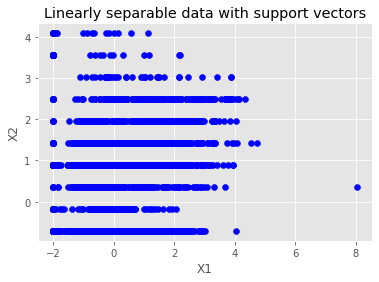

In [59]:
support_vectors = svmGridSearch.best_estimator_.support_vectors_

# Visualize support vectors
plt.scatter(X_train['adr'], X_train['assigned_room_type'], color='blue')
# plt.scatter(support_vectors[:,0], support_vectors[:,1], color='red')
plt.title('Linearly separable data with support vectors')
plt.xlabel('X1')
plt.ylabel('X2')
plt.show()

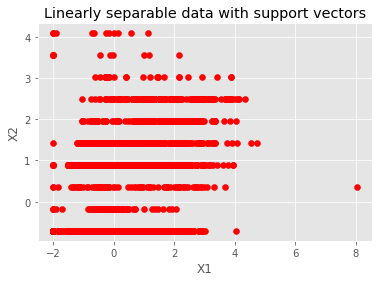

In [60]:
support_vectors = svmGridSearch.best_estimator_.support_vectors_

# Visualize support vectors
# plt.scatter(X_train['adr'], X_train['distribution_channel'], color='blue')
plt.scatter(support_vectors[:,0], support_vectors[:,5], color='red')
plt.title('Linearly separable data with support vectors')
plt.xlabel('X1')
plt.ylabel('X2')
plt.show()

In [41]:
def plot_svc_decision_function(svmGridSearch, ax=None, plot_support=True):
    """Plot the decision function for a 2D SVC"""
    if ax is None:
        ax = plt.gca()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    
    # create grid to evaluate model
    x = np.linspace(xlim[0], xlim[1], 30)
    y = np.linspace(ylim[0], ylim[1], 30)
    Y, X = np.meshgrid(y, x)
    xy = np.vstack([X.ravel(), Y.ravel()]).T
    P = model.decision_function(xy).reshape(X.shape)
    
    # plot decision boundary and margins
    ax.contour(X, Y, P, colors='k',
               levels=[-1, 0, 1], alpha=0.5,
               linestyles=['--', '-', '--'])
    
    # plot support vectors
    if plot_support:
        ax.scatter(model.support_vectors_[:, 0],
                   model.support_vectors_[:, 1],
                   s=300, linewidth=1, facecolors='none');
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

In [44]:
plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=y, s=50, cmap='autumn')
plot_svc_decision_function(msvmGridSearch);

TypeError: '(slice(None, None, None), 0)' is an invalid key

In [96]:
from sklearn.metrics import classification_report



tuned_parameters =  [{
    'alpha': [1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3], # learning rate
    'max_iter': [1000], # number of epochs
    'loss': ['log'], # logistic regression,
    'penalty': ['l2'],
    'n_jobs': [-1],
    'random_state':[10]
}]



log_estimator = SGDClassifier()

logGridSearch = GridSearchCV(estimator=log_estimator
                   , n_jobs=8 # jobs to run in parallel
                   , verbose=1 # low verbosity
                   , param_grid=tuned_parameters
                   , scoring='f1')

logGridSearch.fit(X_train, y_train)

means = logGridSearch.cv_results_['mean_test_score']
stds = logGridSearch.cv_results_['std_test_score']

y_true, y_pred = y_test, logGridSearch.predict(X_test)
print(classification_report(y_true, y_pred))


Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  40 out of  40 | elapsed:    3.2s finished


              precision    recall  f1-score   support

           0       0.76      0.94      0.84     15017
           1       0.83      0.49      0.62      8861

    accuracy                           0.77     23878
   macro avg       0.79      0.72      0.73     23878
weighted avg       0.79      0.77      0.76     23878



In [170]:
 logGridSearch.best_params_

{'alpha': 0.0001,
 'loss': 'log',
 'max_iter': 1000,
 'n_jobs': -1,
 'penalty': 'l2',
 'random_state': 10}

In [97]:
from sklearn.metrics import classification_report



tuned_parameters =  [{
    'alpha': [1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3], # learning rate
    'max_iter': [1000], # number of epochs
    'loss': ['hinge'], # svm,
    'penalty': ['l2'],
    'n_jobs': [-1],
    'random_state':[10]
}]



svm_estimator = SGDClassifier()

svmGridSearch = GridSearchCV(estimator=svm_estimator
                   , n_jobs=8 # jobs to run in parallel
                   , verbose=1 # low verbosity
                   , param_grid=tuned_parameters
                   , scoring='f1')

svmGridSearch.fit(X_train, y_train)

means = svmGridSearch.cv_results_['mean_test_score']
stds = svmGridSearch.cv_results_['std_test_score']

y_true, y_pred = y_test, svmGridSearch.predict(X_test)
print(classification_report(y_true, y_pred))


Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  40 out of  40 | elapsed:    2.4s finished


              precision    recall  f1-score   support

           0       0.72      1.00      0.83     15017
           1       0.99      0.33      0.50      8861

    accuracy                           0.75     23878
   macro avg       0.85      0.67      0.67     23878
weighted avg       0.82      0.75      0.71     23878



In [178]:
 svmGridSearch.best_params_

{'alpha': 0.0001,
 'loss': 'hinge',
 'max_iter': 1000,
 'n_jobs': -1,
 'penalty': 'l2',
 'random_state': 10}

In [179]:
 svmGridSearch.best_estimator_

SGDClassifier(n_jobs=-1, random_state=10)

In [181]:
svmGridSearch.best_estimator_.coef_

array([[-3.56305517e-03,  2.36707960e-02,  6.59604562e-03,
        -3.12169054e-02, -5.76158594e-02, -6.36507896e-02,
         7.64737169e-01, -1.16667405e-02, -8.44919388e-01,
        -3.42802603e-02, -5.91503930e-02,  1.30220214e-01,
        -1.60096259e-03,  4.86489129e-03,  1.74892981e+00,
         2.77110871e-02,  7.72042263e-02,  6.51285659e-02,
         1.45241329e-02]])

# Assess Model<a id='Assess-Model'/>

### Does one type of model offer superior performance over another in terms of prediction accuracy? 


### In terms of training time or efficiency?

#### Logistic regression 

#### Linear SVM
- It took one hour for the gridSearch CV for the linear SVM to process the data. 

#### Non-linear SVM


